In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyscf import gto, scf
from glob import glob
from scf_guess.metrics import f_score

In [2]:
xyz_paths = glob("../data/test_data/geometries/**/*.xyz")
print(f"Found {len(xyz_paths)} molecules")

Found 261 molecules


In [3]:
singlets = []
nonsinglets = []

for i, xyz_path in enumerate(xyz_paths):
    with open(xyz_path, "r") as fin:
        lines = fin.readlines()
    split = lines[1].split()
    q = int(split[split.index("charge") + 1])
    s = int(split[split.index("multiplicity") + 1])
    if not q == 0:
        print(f"{xyz_path} skipped because not charge neutral.")
        continue
    if s == 1:
        singlets.append(xyz_path)
    else:
        nonsinglets.append(xyz_path)

assert len(singlets) == 222
assert len(nonsinglets) == 37

../data/test_data/geometries/vanLenthe2006/CrO4_2-.xyz skipped because not charge neutral.
../data/test_data/geometries/vanLenthe2006/Co(NH3)6.xyz skipped because not charge neutral.


In [4]:
def calculate_guess(mol, guess="hcore"):
    if mol.spin == 0:
        mf = scf.RHF(mol)
    else:
        mf = scf.UHF(mol)

    guess_dens = mf.get_init_guess(key=guess)

    if mol.spin == 0:
        # Factor two to account for double occupation
        Da = Db = guess_dens / 2
    else:
        # Unpack along the first dimension
        Da, Db = guess_dens
    return Da, Db

In [5]:
def load_reference(path):
    ref_data = np.load(path)
    S = ref_data["S"]
    dm = ref_data["dm"]
    # Unpack along the first dimension
    Da, Db = dm
    return Da, Db, S

In [6]:
def score_data_set(paths, guess="hcore", basisset="pcseg-0"):
    f_scores = np.empty(len(paths))
    f_scores.fill(np.nan)

    for i, xyz_path in enumerate(paths):
        with open(xyz_path, "r") as fin:
            lines = fin.readlines()
        # read charge and multiplicity from the comment line and
        # replace the comment line with just these two integers
        split = lines[1].split()
        charge = int(split[split.index("charge") + 1])
        spin = int(split[split.index("multiplicity") + 1]) - 1
        mol = gto.M(atom=xyz_path, basis=basisset, spin=spin, charge=charge)
        s = xyz_path.split("/")
        subset = s[-2]
        name = s[-1].removesuffix(".xyz")
        wfn_path = (
            f"../data/test_data/wavefunctions_pyscf/HF/pcseg-0/{subset}/{name}.npz"
        )
        Da_guess, Db_guess = calculate_guess(mol, guess=guess)
        Da_scf, Db_scf, S = load_reference(wfn_path)
        f_scores[i] = f_score(S, Da_scf, Da_guess, Db_scf, Db_guess)
    return f_scores

| pcseg-0 | singlets | singlets | nonsinglets | nonsinglets |
| ------- | -------- | -------- | ----------- | ----------- | 
| guess   | min $f$  | mean $f$ | min $f$     | mean $f$    |
| GWH     | 0.405    | 0.587    | 0.458       | 0.558       | 
| CORE    | 0.523    | 0.680    | 0.557       | 0.662       | 
| SAD     | 0.711    | 0.908    | 0.739       | 0.871       | 
| SADNO   | 0.758    | 0.973    | 0.861       | 0.959       |
| HUCKEL  | 0.950    | 0.979    | 0.868       | 0.974       |
| CHA-X   | 0.897    | 0.980    | 0.843       | 0.976       |

In [7]:
# Reproduce using the tables S5 and S6 from the SI
ref_guesses = ["GWH", "CORE", "SAD", "SADNO", "HUCKEL", "CHA-X"]
ref_singlets = pd.read_csv(f"../data/reference_tables/Table_S5.csv", index_col=0)
assert len(ref_singlets) == len(singlets)
ref_nonsinglets = pd.read_csv(f"../data/reference_tables/Table_S6.csv", index_col=0)
assert len(ref_nonsinglets) == len(nonsinglets)

pd.DataFrame.from_dict(
    {
        "singlets min": ref_singlets[ref_guesses].min().round(3),
        "singlets mean": ref_singlets[ref_guesses].mean().round(3),
        "nonsinglets min": ref_nonsinglets[ref_guesses].min().round(3),
        "nonsinglets mean": ref_nonsinglets[ref_guesses].mean().round(3),
    }
)

,singlets min,singlets mean,nonsinglets min,nonsinglets mean
GWH,0.405,0.587,0.458,0.558
CORE,0.523,0.680,0.557,0.662
SAD,0.711,0.908,0.739,0.871
SADNO,0.758,0.973,0.861,0.959
HUCKEL,0.950,0.979,0.901,0.964
CHA-X,0.897,0.980,0.843,0.976


In [16]:
# WARNING: this takes quite long
guesses = ["hcore", "minao", "atom", "huckel", "mod_huckel", "sap"]
f_singlets = {"Molecule": [s.split("/")[-1].rstrip(".xyz") for s in singlets]}
f_nonsinglets = {"Molecule": [s.split("/")[-1].rstrip(".xyz") for s in nonsinglets]}

for guess in guesses:
    print(f"Evaluating {guess}...")
    f_singlets[guess] = score_data_set(singlets, guess=guess)
    f_nonsinglets[guess] = score_data_set(nonsinglets, guess=guess)
f_singlets = pd.DataFrame.from_dict(f_singlets).set_index("Molecule")
f_nonsinglets = pd.DataFrame.from_dict(f_nonsinglets).set_index("Molecule")

Evaluating hcore...
Evaluating minao...
Evaluating atom...
Evaluating huckel...
Evaluating mod_huckel...
Evaluating sap...
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found SAP basis sapgrasplarge
Found S

In [17]:
# Just for output:
pd.DataFrame.from_dict(
    {
        "singlets min": f_singlets[guesses].min().round(3),
        "singlets mean": f_singlets[guesses].mean().round(3),
        "nonsinglets min": f_nonsinglets[guesses].min().round(3),
        "nonsinglets mean": f_nonsinglets[guesses].mean().round(3),
    }
)

,singlets min,singlets mean,nonsinglets min,nonsinglets mean
hcore,0.523,0.680,0.562,0.662
minao,0.842,0.917,0.807,0.886
atom,0.846,0.924,0.810,0.892
huckel,0.855,0.957,0.844,0.949
mod_huckel,0.850,0.958,0.850,0.946
sap,0.887,0.975,0.831,0.919


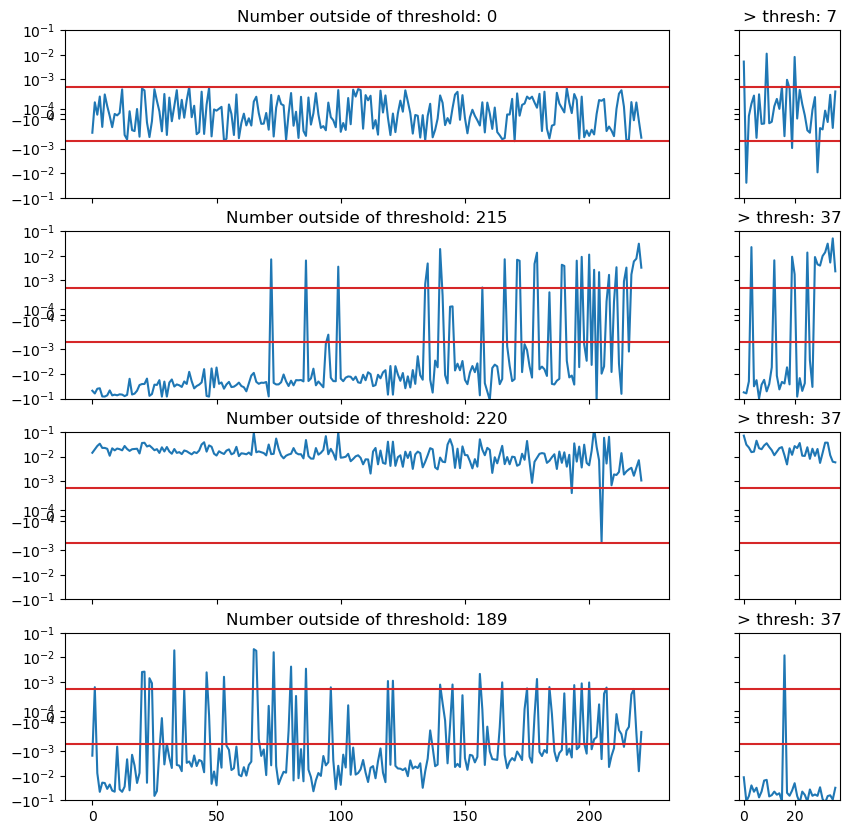

In [18]:
plot_guesses = ["hcore", "huckel", "atom", "sap"]
# Translates a pyscf guess key into the corresponding reference key
guess_dict = {
    "hcore": "CORE",
    "huckel": "HUCKEL",
    "atom": "SAD",
    "minao": "SAD",
    "sap": "CHA-X",
}

fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=len(plot_guesses),
    sharex="col",
    sharey=True,
    gridspec_kw={"width_ratios": [len(singlets), len(nonsinglets)]},
)

thresh = 0.0005
for (ax_singlet, ax_nonsinglet), guess in zip(axes, plot_guesses):
    diff_singlet = (
        f_singlets.loc[ref_singlets.index][guess].values
        - ref_singlets[guess_dict[guess]].values
    )

    ax_singlet.plot(diff_singlet)
    ax_singlet.axhline(thresh, color="C3")
    ax_singlet.axhline(-thresh, color="C3")
    ax_singlet.set_title(
        f"Number outside of threshold: {np.count_nonzero(abs(diff_singlet) > thresh)}"
    )
    ax_singlet.set_yscale("symlog", linthresh=thresh)
    ax_singlet.set_ylim(-0.1, 0.1)

    diff_nonsinglet = (
        f_nonsinglets.loc[ref_nonsinglets.index][guess].values
        - ref_nonsinglets[guess_dict[guess]].values
    )

    ax_nonsinglet.plot(diff_nonsinglet)
    ax_nonsinglet.axhline(thresh, color="C3")
    ax_nonsinglet.axhline(-thresh, color="C3")
    ax_nonsinglet.set_title(
        f"> thresh: {np.count_nonzero(abs(diff_nonsinglet) > thresh)}"
    )
    ax_nonsinglet.set_yscale("symlog", linthresh=thresh)
    ax_nonsinglet.set_ylim(-0.1, 0.1)


In [11]:
guess = "hcore"
diff_singlet = (
    f_singlets.loc[ref_singlets.index][guess].values
    - ref_singlets[guess_dict[guess]].values
)
print(ref_singlets.index[np.where(abs(diff_singlet) > thresh)])

Index([], dtype='object', name='Molecule')


In [12]:
guess = "hcore"
diff_nonsinglet = (
    f_nonsinglets.loc[ref_nonsinglets.index][guess].values
    - ref_nonsinglets[guess_dict[guess]].values
)
print(ref_nonsinglets.index[np.where(abs(diff_nonsinglet) > thresh)])

Index(['ch', 'cch', 'cf', 'clo', 'c-hooo', 'sif', 'no'], dtype='object', name='Molecule')
